May 18, 2020: We will make learning curves for our estimator

In [20]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import dask

In [21]:
from estimator import RFClassifier, relu, bp_weights_dft
from data_fns import pure_sine_dft

In [22]:
from dask.distributed import Client
client = Client(threads_per_worker=7, n_workers=10)
client

Client Scheduler: tcp://127.0.0.1:41489 Dashboard: http://127.0.0.1:40455/status,Cluster Workers: 10 Cores: 70 Memory: 135.06 GB


In [23]:
nPoints, fs, sig_dur = 10000, 1500, 0.1
k, a = 8, 0.8
X, y = pure_sine_dft(nPoints, fs, k, sig_dur, a, seed=20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

In [24]:
f_dft = lambda M, N: bp_weights_dft(M, N, lowcut=k-3, highcut=k+3)

def l_clf(classifier, params, X_train, y_train, X_test, y_test):
    clf = classifier(**params)
    clf.fit(X_train, y_train)
    # Estimate the Rademacher complexity
    phi = clf.transform(X_train)
    trace_K = la.norm(phi, 'fro') ** 2
    # norm of the coefficient
    clf_coef_norm = la.norm(clf.clf.coef_)
    return [trace_K, clf_coef_norm, 1 - clf.score(X_test, y_test), 1 - clf.score(X_train, y_train)]

In [30]:
n_features = sorted(set(np.logspace(0, 3, 20).astype('int')))
train_size = np.arange(5, len(X_train), 100)
print(n_features)

[1, 2, 4, 6, 8, 12, 18, 26, 37, 54, 78, 112, 162, 233, 335, 483, 695, 1000]


In [31]:
%%time 
results = {n: [] for n in n_features}
for n in n_features:
    params = {'width': n, 'weights':'bandpass', 'weight_fun':f_dft, 'nonlinearity':relu}
    for t in train_size:
        X_val, _, y_val, _ = train_test_split(X_train, y_train, train_size=t, random_state=2)
        lazy_results = [dask.delayed(l_clf)(RFClassifier, params, X_val, y_val, X_test, 
                                                y_test) for _ in range(5)]

        results[n].append(np.real(dask.compute(*lazy_results)))   

CPU times: user 2min 36s, sys: 1min 4s, total: 3min 41s
Wall time: 8min 56s


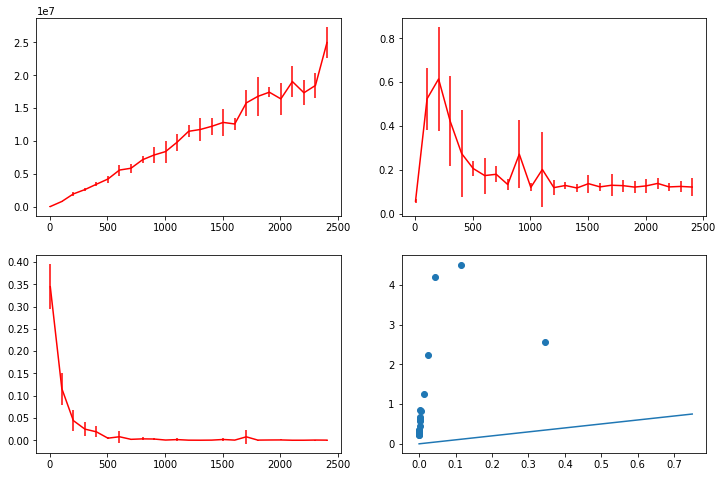

In [181]:
i = 26
fig = plt.figure(figsize=(12, 8))
mean_tr, mean_wt_norm, mean_test_err, mean_train_err  = np.split(np.mean(results[i], axis=1), 4, axis=1)
std_tr, std_wt_norm, std_test_err, std_train_err = np.split(np.std(results[i], axis=1), 4, axis=1)
gen_err = mean_test_err.flatten() - mean_train_err.flatten()
complexity = np.sqrt(mean_tr.flatten()) * mean_wt_norm.flatten() / train_size

ax = fig.add_subplot(221)
ax.errorbar(train_size, mean_tr.flatten(), yerr=std_tr.flatten(), c='r')

ax = fig.add_subplot(222)
ax.errorbar(train_size, mean_wt_norm.flatten(), yerr=std_wt_norm.flatten(), c='r')

ax = fig.add_subplot(223)
ax.errorbar(train_size, mean_test_err.flatten(), yerr=std_test_err.flatten(), c='r')

ax = fig.add_subplot(224)
ax.scatter(gen_err, complexity)
plt.plot(np.arange(0, 1, 0.25), np.arange(0, 1, 0.25))

In [157]:
xx = np.array(list(results.values()))
yy = np.mean(xx, axis=2)
zz = np.concatenate(yy, axis=0)

t_size = np.array([train_size] * len(n_features))

In [196]:
tr_all, wt_norm_all, test_err_all, train_err_all = np.split(zz, 4, axis=1)
gen_err_all = test_err_all - train_err_all
complexity_all = np.sqrt(tr_all) * wt_norm_all / t_size.reshape(-1, 1)

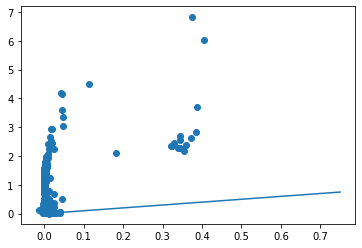

In [199]:
fig = plt.figure()
plt.scatter(gen_err_all, complexity_all)
plt.plot(np.arange(0, 1, 0.25), np.arange(0, 1, 0.25))

(450, 1)

In [121]:
complexity_all.shape

(450, 450)